A notebook to read the DECaPS individual image catalogs for 5% and 20% fields (since those got successfully processed with the LSST Stack). The 1% region (c4d_170428_094150_ooi_g.fitz.fz  , 0644297) for which I also have DECaPS catalog was too crowded for the Stack to handle it. Fields and catalogs :


LSST catalogs : outDir = '../data_products/LSST_Stack/DECam/' 
DECaPS catalogs  : decapsDir = '../data_products/DEcAPS_catalogs/'

g - band , 20 % , 96 sec exposure,  ra 120.88400  dec -24.031667  , ccd 10  :
'calexp-0611980_10.fits'  for MAGZERO , src-0611980_10.fits  for sources 
decaps : c4d_170122_055542_ooi_g_v1.cat.fits

* same g-band 20% region,  but ccd11 : 
calexp-0611529_11.fits   ,  src-0611529_11.fits   
( same decaps as above) 

r - band , 20 % , 50 sec exposure , ra 120.886500  dec -24.025972   , ccd 10 :
'calexp-0611529_10.fits'  for MAGZERO , 'src-0611529_10.fits'  for sources 
decaps  : c4d_170121_055805_ooi_r_v1.cat.fits


5% region : 0527064    ccd 10 : 
'calexp-0527064_10.fits ' for MAGZERO , 'src-0527064_10.fits' for sources
decaps : c4d_160316_065235_ooi_g_v1.cat.fits


In [2]:
# Necessary imports ..

import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize


Aim : to plot, per catalog, per density level : 
        * completeness (how many of the 'true' sources were detected by LSST Stack per magnitude bin) vs. magnitude curve
        * photometric error (rms for true minus measured mag) vs. mag curve

In [ ]:
To do the above, need:
    * match by ra, dec stack source catalog and decaps catalog
    * convert lsst source fluxes to mags using the zero point magnitude from calexp image 
    * 

In [304]:
# Read-in DEcAPS catalog for 20% region
outDir = '../data_products/DEcAPS_Catalogs/'
fname = 'c4d_170122_055542_ooi_g_v1.cat.fits'
hdu = fits.open(outDir + fname)
#http://www.astropy.org/astropy-tutorials/FITS-tables.html
hdu.info()
# this displays all available CCDs... 
# Those processed for the object 0611980 are ccd10 and ccd11,
# that corresponds to S22 and S23 , i.e. hdu[25:27],  and hdu[28:30]...

# S22  :  hdu[25] : S22_HDR     ImageHDU       129   (0,)    
# S22  :  hdu[26] : S22_PSF     BinTableHDU     19   8R x 4C   [2E, 1444E, 10E, 810E]   
# S22  :  hdu[27] : S22_CAT     BinTableHDU     47   4731R x 19C   [D, D, E, E, E, E, E, E, E, E, E, E, J, E, J, D, D, K, E]

Filename: ../data_products/DEcAPS_Catalogs/c4d_170122_055542_ooi_g_v1.cat.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     250   ()      
  1  S29_HDR     ImageHDU       129   (0,)      
  2  S29_PSF     BinTableHDU     19   8R x 4C   [2E, 1444E, 10E, 810E]   
  3  S29_CAT     BinTableHDU     47   4808R x 19C   [D, D, E, E, E, E, E, E, E, E, E, E, J, E, J, D, D, K, E]   
  4  S31_HDR     ImageHDU       129   (0,)      
  5  S31_PSF     BinTableHDU     19   8R x 4C   [2E, 1444E, 10E, 810E]   
  6  S31_CAT     BinTableHDU     47   4383R x 19C   [D, D, E, E, E, E, E, E, E, E, E, E, J, E, J, D, D, K, E]   
  7  S25_HDR     ImageHDU       129   (0,)      
  8  S25_PSF     BinTableHDU     19   8R x 4C   [2E, 1444E, 10E, 810E]   
  9  S25_CAT     BinTableHDU     47   4595R x 19C   [D, D, E, E, E, E, E, E, E, E, E, E, J, E, J, D, D, K, E]   
 10  S26_HDR     ImageHDU       129   (0,)      
 11  S26_PSF     BinTableHDU     19   8R x 4C   [2E, 1444E,

In [305]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2017-01-25T00:50:36' / Date FITS file was generated                  
IRAF-TLM= '2017-01-25T16:27:45' / Time of last modification                     
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
OBJECT  = 'DECaPS_14397_g'     / Name of the object observed                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT MODIFIED:DATE,DATE-OBS,DTACQNAM,DTCALDAT,DTCOPYRI,DTINSTRU,DTNSANAM,DTOB
COMMENT SERV,DTPI,DTPIAFFL,DTPROPID,DTSITE,DTTELESC,DTTITLE,INSTRUME,OBSERVAT,OB
COMMENT SID,OBSTYPE,PROCTYPE

In [310]:
np.arange(1,5)

array([1, 2, 3, 4])

In [312]:
centra = hdu[0].header['CENTRA']
centdec  = hdu[0].header['CENTDEC']
corner_dic = {'ra':np.zeros(4), 
              'dec':np.zeros(4)}

for corner in np.arange(1,5) : 
    corn_ra = 'CORN'+str(corner)+'RA'
    corn_dec  = 'CORN'+str(corner)+'DEC'
    corner_dic['ra'][corner-1] = hdu[0].header[corn_ra]
    corner_dic['dec'][corner-1] = hdu[0].header[corn_dec]



In [313]:
corner_dic

{'dec': array([-25.010257, -25.010257, -23.052235, -23.052235]),
 'ra': array([ 119.699147,  122.068811,  119.699147,  122.068811])}

In [27]:
zeropoint = hdu[0].header['MAGZERO']  # one per entire image composed of multiple CCDs
exptime = hdu[0].header['EXPTIME']

 m = K – 2.5 log ( Flux )
 
 * K is the photometric "zero point"
 * Flux = Gain * Counts / Exptime.

The camera gain ("Gain") and exposure time ("Exptime") are obtained from the FITS keywords GAIN and EXPTIME. The value of Counts is the net signal from the object, above the sky background, and measured in the raw pixel value units (often called "ADU's"). The Flux therefore represents a total number of electrons per second attributable to the object, above the sky.

s22_cat['flux'] : ADUs - Counts  
s22_cat['gain'] : (e-/ADU) 

In [16]:
# convert the catalog for ccd10 , called s22, 
# to AstroPy Table : 
s22_cat =  Table(hdu[27].data) 

In [43]:
s22_cat['mag'] = -2.512 * np.log10(s22_cat['flux'].data) + zeropoint

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


In [396]:
#s22_cat['mag']

In [117]:
# Load the LSST Stack for ccd10 : 
outDir = '../data_products/LSST_Stack/DECam/'
fname = 'calexp-0611980_10.fits'
hdu = fits.open(outDir + fname)
g_zeropoint = hdu[0].header['MAGZERO']

fname = 'src-0611980_10.fits'
hdu = fits.open(outDir + fname)
g_data = Table(hdu[1].data)

mask_neg_fluxes = g_data['base_PsfFlux_flux'].data > 0
# just select rows that don't have negative fluxes...
g_data_good = g_data[mask_neg_fluxes]
g_data_good['mags_PsfFlux'] = -2.512 * np.log10(g_data_good['base_PsfFlux_flux'])   + g_zeropoint

In [48]:
# match the ccd10 s22 catalog to ccd10 LSST Stack by ra ,dec ; 
len(g_data_good)

4370

In [118]:
#s22_cat['dec']

In [151]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# all g-band 
# decam coordinates
decam_coord = SkyCoord(ra  = s22_cat['ra']*u.degree, 
                       dec = s22_cat['dec']*u.degree)  
print(len(decam_coord))

# lsst coordinates : in radians ! 
lsst_coord = SkyCoord(ra = g_data_good['coord_ra']*u.radian, 
                      dec= g_data_good['coord_dec']*u.radian)  
print(len(lsst_coord))

# indices are into r_coord catalog 
idx, d2d, d3d = lsst_coord.match_to_catalog_sky(decam_coord)  

# select only DECam fields that are matched to MAF 
#matches = r_coord[idx]


4731
4370


# Given coords of the center of the decaps image, which tiles to take form decaps ?

In [290]:
# Read-in DEcAPS catalog for 20% region
outDir = '../data_products/DEcAPS_Catalogs/'
fname = 'c4d_170122_055542_ooi_g_v1.cat.fits'
hdu = fits.open(outDir + fname)


centra = hdu[0].header['CENTRA']
centdec  = hdu[0].header['CENTDEC']
corner_dic = {'ra':np.zeros(4), 
              'dec':np.zeros(4)}

for corner in np.arange(1,5) : 
    corn_ra = 'CORN'+str(corner)+'RA'
    corn_dec  = 'CORN'+str(corner)+'DEC'
    corner_dic['ra'][corner-1] = hdu[0].header[corn_ra]
    corner_dic['dec'][corner-1] = hdu[0].header[corn_dec]


# the coordinates of the field 
# expressed in galactic longitude (l) and latitude (b) : 
#radec = SkyCoord(ra = 120.884 * u.degree , dec = -24.031667 * u.degree)
#print('l,b = %f,%f'%(radec.galactic.b.degree, radec.galactic.l.degree))
#l_field, b_field = radec.galactic.l.degree, radec.galactic.b.degree


l,b = 3.773824,242.428415


In [391]:
# initialize corners and center of the field in degrees 
corners  = SkyCoord(ra = corner_dic['ra'] * u.degree, 
                   dec = corner_dic['dec']*u.degree)
center = SkyCoord(ra = centra * u.degree, dec = centdec * u.degree)

# print
print('This DECaPS field is centered on ')
print('l,b = %f, %f'%(center.galactic.l.degree, center.galactic.b.degree))

This DECaPS field is centered on 
l,b = 242.428426, 3.773817


In [392]:
# note: handle both positive and negative cases of galactic latitude, 
# since longitude is always positive

# Make an array of tile latitudes: 

# closest  half integer to the maximum latitude:
top_latitude = np.ceil(max(corners.galactic.b.degree)) 
bottom_latitude = np.floor(min(corners.galactic.b.degree))
latitudes = np.arange(bottom_latitude, top_latitude) + 0.5


# Make an array of tile longitudes 

maxL = max(corners.galactic.l.degree) 
minL = min(corners.galactic.l.degree)
if maxL - minL > 200 : 
    # the boundary case ( around 0 longitude)
    left_longitude = np.floor(maxL)
    right_longitude = np.ceil(minL)
    a = np.arange(left_longitude, 360 ) +0.5
    longitudes = np.append(a, np.arange(1,right_longitude)-0.5) 
else : 
    # the standard case (both on same side )
    left_longitude = np.floor(minL)
    right_longitude = np.ceil(maxL)
    longitudes = np.arange(left_longitude, right_longitude) + 0.5
    

from itertools import product
# https://faun.rc.fas.harvard.edu/decaps/release/band-merged/decam_flux_l1.5bm6.5.fits 
decaps_catalogs = []
for lat,lon in product(latitudes, longitudes):
    if lat >= 0 : 
        catname = 'decam_flux_l' + str(lon) + 'b'  + str(lat) + '.fits'
    if lat < 0 : 
        catname  = 'decam_flux_l' + str(lon) + 'b'  + 'm' + str(lat)[1:]+ '.fits'
    decaps_catalogs.append(catname)
    
    
print('We will download')
print(decaps_catalogs)
    
    

We will download
['decam_flux_l241.5b2.5.fits', 'decam_flux_l242.5b2.5.fits', 'decam_flux_l243.5b2.5.fits', 'decam_flux_l241.5b3.5.fits', 'decam_flux_l242.5b3.5.fits', 'decam_flux_l243.5b3.5.fits', 'decam_flux_l241.5b4.5.fits', 'decam_flux_l242.5b4.5.fits', 'decam_flux_l243.5b4.5.fits', 'decam_flux_l241.5b5.5.fits', 'decam_flux_l242.5b5.5.fits', 'decam_flux_l243.5b5.5.fits']


In [394]:
# Note - this may take a while to run because it 
# will download all the needed catalog tiles ... 
import urllib.request
for file in decaps_catalogs : 
    file_name = '../data_products/DEcAPS_Catalogs/band_merged/'+file
    url = 'https://faun.rc.fas.harvard.edu/decaps/release/band-merged/'+file
    urllib.request.urlretrieve(url, file_name)

('../data_products/DEcAPS_Catalogs/band_merged/decam_flux_l241.5b2.5.fits',
 <http.client.HTTPMessage at 0x12110a710>)

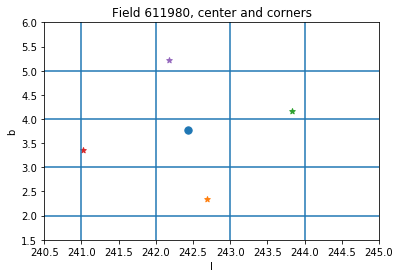

In [393]:
# NOTE : The illustration only really works  for positive latitude, ( eg. b = 3,6 )
# and both longitudes must be on the same side of the 0 meridian ( eg. l = 241, 245)

# The decaps fields are arranged as a grid of 
# fields : 
l_field, b_field = center.galactic.l.degree, center.galactic.b.degree

lmin = np.floor(l_field) - 1 
bmin = np.floor(b_field) - 1
fig,ax = plt.subplots(1,1)
for l in np.arange(lmin,lmin+4) :
    ax.axvline(l)
for b in np.arange(bmin,bmin+4):
    ax.axhline(b)
ax.set_xlim(lmin-0.5,lmin+4)
ax.set_ylim(bmin-0.5, bmin+4)
ax.scatter(l_field, b_field, s=54)
for c in corners : 
    ax.scatter(c.galactic.l, c.galactic.b, s=34, marker='*')
ax.set_xlabel('l')
ax.set_ylabel('b')
ax.set_title('Field 611980, center and corners')

### Completeness : match the decals single-epoch catalog to LSST source catalog 

We match the decals catalog that corresponds exactly to the LSST-processed image, CCD by CCD. 
1) Read the LSST source catalog for a given CCD 

In [152]:
from astropy.table import hstack
lsst_decam= hstack([g_data_good , s22_cat[idx]],
                   table_names=['decam','lsst']  )

In [163]:
good_matches=  lsst_decam[d2d.arcsec < 2][['mag', 'mags_PsfFlux']]

In [168]:
lsst= good_matches['mags_PsfFlux'].data
decaps = good_matches['mag'].data

In [182]:
len(lsst_decam)

4370

Plot the DECaPS matches to LSST Stack detections within 2 arcsec in image c4d_170122_055542_ooi_g_v1.cat.fits, i.e. 0611980_10, ccd10, i.e. S22 :  

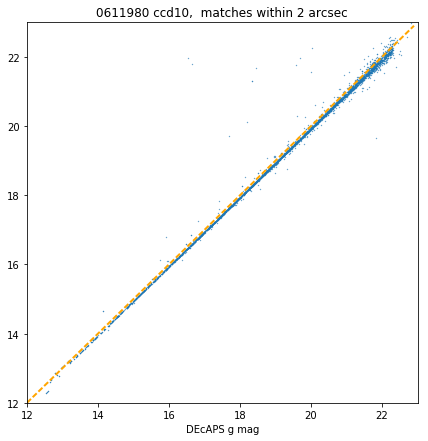

In [179]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(lsst,decaps, s=0.09)
x = np.arange(12,23,0.1)
ax.plot(x,x, ls='--', lw=2, color='orange')
ax.set_xlim(12,23)
ax.set_ylim(12,23)
ax.set_xlabel('LSST Stack g mag ')
ax.set_xlabel('DEcAPS g mag')
ax.set_title('0611980 ccd10,  matches within 2 arcsec')

In [187]:
# How many decaps stars do we recover ? 

# all g-band 
# decam coordinates
decam_coord = SkyCoord(ra  = s22_cat['ra']*u.degree, 
                       dec = s22_cat['dec']*u.degree)  
print(len(decam_coord))

# lsst coordinates : in radians ! 
lsst_coord = SkyCoord(ra = g_data_good['coord_ra']*u.radian, 
                      dec= g_data_good['coord_dec']*u.radian)  
print(len(lsst_coord))

# indices are into r_coord catalog 
idx, d2d, d3d = decam_coord.match_to_catalog_sky(lsst_coord)  

# select only DECam fields that are matched to MAF 
#matches = r_coord[idx]

from astropy.table import hstack
lsst_decam= hstack([g_data_good[idx] , s22_cat],
                   table_names=['decam','lsst']  )


4731
4370


In [204]:
# How many decaps have an lsst match within 5 arcsec ? 
matched = lsst_decam[d2d.arcsec < 5][['mag', 'mags_PsfFlux']]
np.sum(d2d.arcsec < 5)

4150

In [395]:
print()

0.8723404255319149

In [206]:
matched['dmag'] = matched['mag'] - matched['mags_PsfFlux']

In [207]:
# How many decaps have an lsst match within 5 arcsec 
# and they don't differ by more than half magnitude  ? 
print(np.sum(abs(matched['dmag']) < 0.5))
mask = abs(matched['dmag']) < 0.5

3531


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


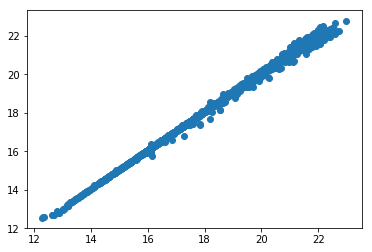

In [203]:
plt.scatter(matched['mag'][mask], matched['mags_PsfFlux'][mask])

In [212]:
diff = matched['mag'][mask] -matched['mags_PsfFlux'][mask]


In [214]:
rms = lambda x : np.sqrt(np.mean(np.square(x)))

In [255]:
from scipy.stats import binned_statistic as bs
bins = np.arange(12,23,0.5)
stat = bs(matched['mag'][mask], diff, bins =bins ,statistic=rms)

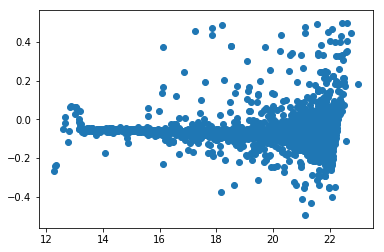

In [264]:
# just plot the difference between measured (lsst) and true (decam) magnitudes ... 
plt.scatter(matched['mag'][mask], diff)

In [237]:
# nice test of statistics :
# the more samples we draw from a normal 
# distribution, 
# the mode the rms approaches the 
# standard deviation ...
a = np.random.normal(loc=0, scale=1.2, size=5000)
print(rms(a))
print(np.std(a))

1.20315088855
1.20312498142


In [256]:
stat.bin_edges

array([ 12. ,  12.5,  13. ,  13.5,  14. ,  14.5,  15. ,  15.5,  16. ,
        16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,  20. ,  20.5,
        21. ,  21.5,  22. ,  22.5])

In [262]:
stat.statistic

array([ 0.24780538,  0.06555947,  0.04933639,  0.05535924,  0.06040687,
        0.05779488,  0.05637198,  0.06025317,  0.07716282,  0.06911305,
        0.07708015,  0.08355789,  0.08165595,  0.08401285,  0.08188009,
        0.08425099,  0.0909726 ,  0.09756736,  0.11225054,  0.12819406,
        0.14216897])

In [257]:
len(bins)

22

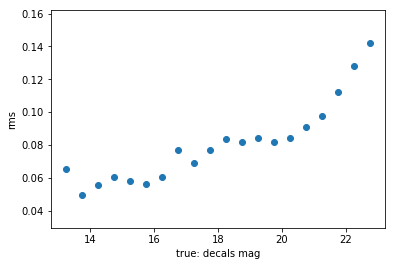

In [268]:
plt.scatter(stat.bin_edges[2:]+0.25, stat.statistic[1:])
plt.ylabel('rms')
plt.xlabel('true: decals mag')